Tests for the ChessEvalPosNet 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from config import Config 
from data import ChessDataset, EvalDataset
from complex_cnn.complex_model import ChessNet
from preprocess import *
from test import test_piece_accuracy
from complex_cnn.complex_model import ChessPosEvalNet
from utils import tensor_to_board
config = Config()
import pandas as pd
import numpy as np
import chess

In [3]:
train_chess_data = preprocess_eval_data(f'{config.eval_dataset_dir}/train_dataset.csv')
train_chess_data

,FEN,Evaluation,Evaluation_std
0,3r2k1/5ppp/4p3/p7/b3PP2/3R1BP1/P1p4P/2K5 b - -...,-2500,-2.106438
1,3r1rk1/2R1qp2/p2p1n1p/1p4p1/2Qpb3/1P4B1/P3BPPP...,-548,-0.475346
2,1k1r2n1/ppp3p1/3p1pb1/3Np1q1/2P1P3/P2P4/1P3r2/...,1056,0.864957
3,r1bq1rk1/ppp2pp1/2np1n1p/2b1p3/2P1P3/3P1N1P/PP...,-32,-0.044177
4,2kr1br1/2qn1p2/bp2p1p1/1Np1P3/P1P5/5N2/1BQ2PPP...,886,0.722905
...,...,...,...
700186,5nr1/2q3k1/p4npp/2p1p3/2P1B3/5NP1/P6P/R1Q2NK1 ...,504,0.403705
700187,r2q1rk1/pp2bppp/2b2n2/3p4/3Q4/2N1P3/PP1N1PPP/R...,-13,-0.028300
700188,r3k2r/p2nbpp1/2p1pnp1/q7/1p1P1BP1/1BN4P/PPP1QP...,-12,-0.027465
700189,2krr3/1bq3pp/ppp2p2/2nR4/1PP1p3/P1B1PBP1/1Q3P1...,-609,-0.526318


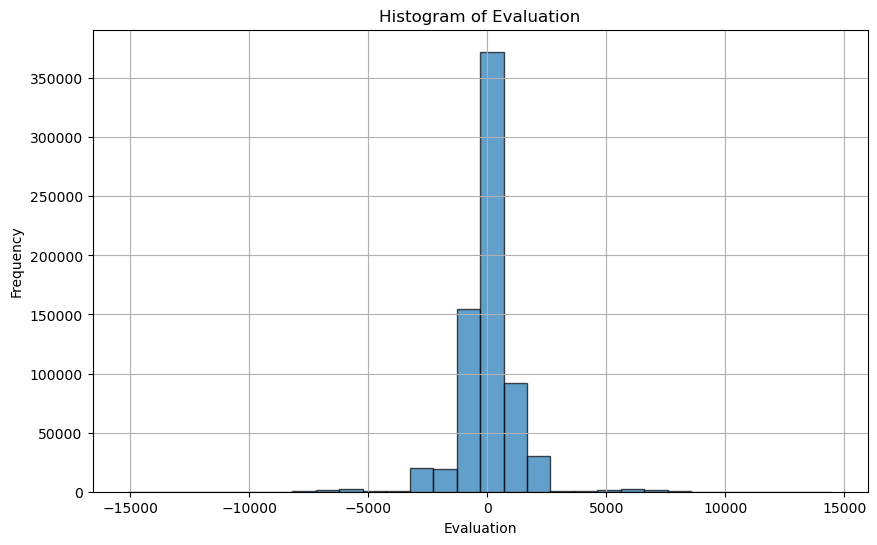

In [28]:
import matplotlib.pyplot as plt
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size (adjust as needed)

# Replace 'evaluation' with the actual column name from your DataFrame
plt.hist(train_chess_data['Evaluation'], bins=30, edgecolor='k', alpha=0.7)  # Adjust the number of bins as needed
plt.title('Histogram of Evaluation')
plt.xlabel('Evaluation')
plt.ylabel('Frequency')

plt.grid(True)  # Add grid lines if desired

plt.show()

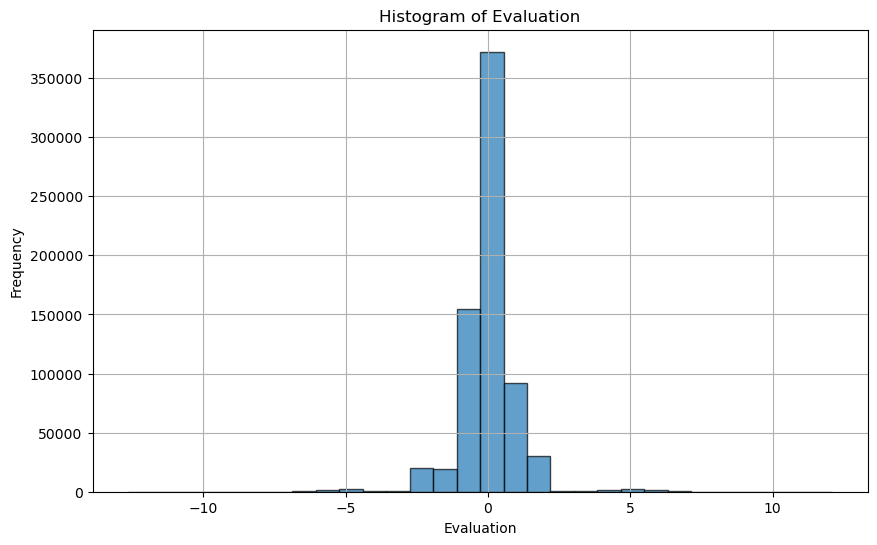

In [30]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size (adjust as needed)

# Replace 'evaluation' with the actual column name from your DataFrame
plt.hist(train_chess_data['Evaluation_std'], bins=30, edgecolor='k', alpha=0.7)  # Adjust the number of bins as needed
plt.title('Histogram of Evaluation')
plt.xlabel('Evaluation')
plt.ylabel('Frequency')

plt.grid(True)  # Add grid lines if desired

plt.show()

In [83]:
games = train_chess_data
game_idx = np.random.randint(len(games))
board_fen = games.values[game_idx][0]
board_eval = games.values[game_idx][1]
board = chess.Board(board_fen)
x = board_to_rep(board)
y = board_eval

In [55]:
model_name = 'cnn_board_eval.pth'
saved_model = ChessPosEvalNet(hidden_layers=4, hidden_size=200)
PATH_name = f"/home/tamiroffen/AI_Project/project/saved_models/{model_name}"
saved_model.load_state_dict(torch.load(PATH_name))
saved_model.to(config.device)
saved_model.eval()

ChessPosEvalNet(
  (input_layer): Conv2d(6, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_list): ModuleList(
    (0-3): 4 x module(
      (conv1): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): SELU()
      (activation2): SELU()
    )
  )
  (fc1): Linear(in_features=12800, out_features=6400, bias=True)
  (fc2): Linear(in_features=6400, out_features=1, bias=True)
)

In [4]:
test_chess_data = preprocess_eval_data(f'{config.eval_dataset_dir}/test_dataset.csv')
data_test = EvalDataset(test_chess_data, 10000)

In [5]:
data_test_loader = DataLoader(data_test, batch_size=1, shuffle=False, drop_last=True)

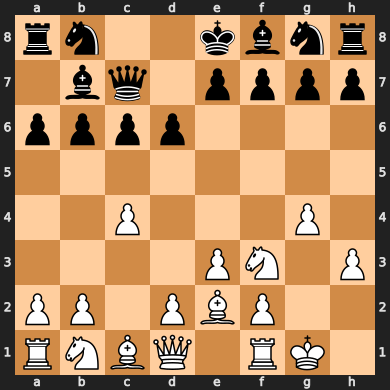

0.002422657332821647


In [6]:
data_iter = iter(data_test_loader)
one_batch = next(data_iter)
x, y = one_batch
x = x.squeeze(0)
board = tensor_to_board(x)
display(board)
print(y.item())

y_true = 0.435
y_pred = -1.498


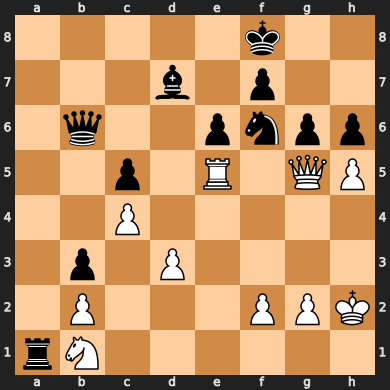

In [29]:
data_iter = iter(data_test_loader)
one_batch = next(data_iter)
x, y = one_batch
x = x.to(config.device).float()
y = y.to(config.device).float()
output = saved_model(x)
print(f"y_true = {round(y.item(), 3)}")
print(f"y_pred = {round(output.item(), 3)}")

x = x.squeeze(0)
board = tensor_to_board(x)
display(board)

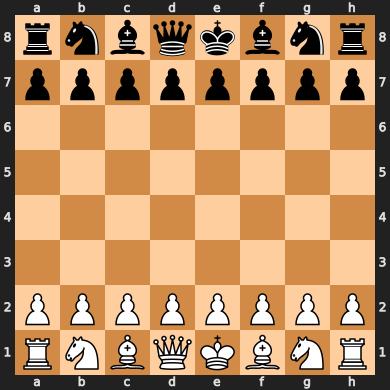

model prediction: 0.622


In [86]:
board = chess.Board()
# board.push_san("e4")
# board.push_san("e5")
# board.push_san("Qh5")
# board.push_san("Nc6")
# board.push_san("Bc4")
# # board.push_san("Nf6")
# board.push_san("Nh6")
x = torch.tensor(board_to_rep(board))
x = x.unsqueeze(0)
x = x.to(config.device).float()
output = saved_model(x)
display(board)
print(f'model prediction: {round(output.item(),3)}')

In [19]:
criterion = nn.MSELoss()
loss = criterion(output, y)

In [20]:
loss

tensor(12658.8125, device='cuda:0', grad_fn=<MseLossBackward0>)